In [ ]:
!pip install transformers
!pip install datasets
!pip install torch==2.4.0
!pip install torchvision==0.19.0
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.2/797.2 MB 1.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 64.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 50.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 1.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.7 MB/s eta 0:00:000:00:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 5.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.4 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 3.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━

In [ ]:
import transformers

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.nn import BCEWithLogitsLoss

from torch.utils.data import DataLoader
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModel,
    DataCollatorWithPadding,
    AutoConfig
)

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

Для скорости будем использовать gpu

In [ ]:
device_num = 0
device = "mps" if torch.backends.mps.is_available() else f"cuda:{device_num}" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

### Описание задачи
Будем работать с данными с [соревнования](https://boosters.pro/championship/HeadHunter/overview) от HeadHunter. Нам предстоит предсказать причины которые закодированы числами от 1 до 8, по которым отзыв на работадателя не проходит модерацию. Причин, по которым отзыв не прошёл модерацию может быть несколько. Если отзыв проходит модерацию, то вместо причины отказа нужно предсказывать 0. Значение 0 разрешается комбинировать с причинами отказа.

Таким образом, мы имеем дело с задачей *multi-label классификации*.
Самый простой и популярный способ работать с multi-label задачей классификации &mdash; перейти к бинарной. Для каждого класса мы ставим метку 1, если он присутствует в таргете, а 0 &mdash; иначе. В процессе обучения мы будем минимизировать бинарную кросс-энтропию.

В качестве целевой метрики будем использовать $F_1$-score с усреднением по сэмплам.

$$
F_1 = \frac{1}{n}\sum_{i=1}^n 2\frac{precision_i recall_i}{precision_i + recall_i},
$$
где $n$ &mdash; размер выборки, а $precision_i, recall_i$ &mdash; precision/recall для i-го объекта.

### Работа с данными

Загрузим обучающий датасет.

In [ ]:
data = pd.read_csv("/kaggle/input/data-nlp-3/HeadHunter_train.csv")
data.head(5)

,review_id,city,position,positive,negative,salary_rating,team_rating,managment_rating,career_rating,workplace_rating,rest_recovery_rating,target
0,0,Ижевск,Кладовщик,Недавно устроился в ****** на должность кладов...,Повысить з/п,5,4,3,3,4,4,0
1,1,Москва,Руководитель проекта,"Расположение офиса, своего рода стабильность (...",Упростить процессы - все процессы ради процесс...,4,4,4,1,1,1,8
2,2,Екатеринбург,Консультант,В нашем банке все по закону в плане зарплаты и...,Ничего,5,5,5,5,5,5,0
3,5,Санкт-Петербург,Оператор,Я в ****** около года работаю оператором. Норм...,Нет.,5,5,5,5,5,5,0
4,7,Москва,Инженер КИПиА,В принципе норм.Работать можно,Всегда есть к чему стремиться,4,5,4,2,5,2,8


Как можно увидеть, помимо положительного `positive` и отрицательного `negative` текста отзывов, мы также имеем некоторое количество категориальных признаков, с которыми мы пока не будем работать. Целевая переменная расположена в колонке `target` и представляет из себя строку, разделенную запятыми.

Посмотрим, какие значения может принимать целевая переменная.

In [ ]:
data["target"].unique()

array(['0', '8', '7', '1,8', '3,8', '6,8', '6', '3', '1', '1,6', '4,8',
       '5', '5,8', '1,5', '7,8', '4', '5,6', '1,4', '1,6,8', '1,7',
       '1,5,8', '1,3,8', '1,3', '1,4,6', '4,6', '1,3,5', '3,5,8', '1,5,6',
       '1,4,8', '1,2,6', '5,7', '3,5', '5,6,8', '1,3,6', '3,7', '2',
       '1,7,8', '3,6,8', '6,7', '4,6,8', '5,7,8', '3,6', '1,5,6,8',
       '3,5,7'], dtype=object)

Посмотрим на примеры отзывов, которые не прошли модерацию.

In [ ]:
data[data["target"] == "5,8"]["positive"].values[13]

'Известная компания.....................................................................................................'

In [ ]:
data[data["target"] == "3,8"]["positive"].values[29]

'Хужбвб влвлв в вщвлу у улыды ыыд'

In [ ]:
data = data[['positive', 'negative', 'target']]
data

,positive,negative,target
0,Недавно устроился в ****** на должность кладов...,Повысить з/п,0
1,"Расположение офиса, своего рода стабильность (...",Упростить процессы - все процессы ради процесс...,8
2,В нашем банке все по закону в плане зарплаты и...,Ничего,0
3,Я в ****** около года работаю оператором. Норм...,Нет.,0
4,В принципе норм.Работать можно,Всегда есть к чему стремиться,8
...,...,...,...
50871,Ни чего ни чего ни чего ни чего,Всё всё Всё всё Всё всё Всё всё Всё всё Всё всё,"3,8"
50872,Есть исключительно хорошие руководители.,Удачи хорошем управляющим в компании.,8
50873,Уютная столовая .раздевалка,График работы. Обучение сотрудников,8
50874,"Не соблюдают трудовой кодекс, переработки 7 д...",Рабская эксплуатация работников,1


In [ ]:
data['target'] = data['target'].apply(lambda x: list(map(int, x.split(','))))

mlb = MultiLabelBinarizer(classes=[0, 1, 2, 3, 4, 5, 6, 7, 8])

binary_target = mlb.fit_transform(data['target'])

for i, class_label in enumerate(mlb.classes_):
    data[f'target_{class_label}'] = binary_target[:, i]

Разделите выборку на обучающую и валидационную.

In [ ]:
train_data, val_data, train_labels, val_labels = train_test_split(
    data[['positive', 'negative']],
    data.iloc[:, 3:],
    test_size=0.25,
    random_state=42
)

In [ ]:
train_data.shape, train_labels.shape, val_data.shape, val_labels.shape,

((38157, 2), (38157, 9), (12719, 2), (12719, 9))

### Токенизация и реализация метрики качества

Теперь реализуем вышеупомянутую метрику, а именно $F_1$-score с усреднением по сэмплам.

Когда $precision = recall = 0$ будем считать F1-score равным 0, чтобы не произошло деление на 0

In [ ]:
def calculate_f1_score(preds, targets):
    """
    Функция подсчета F1-score с усреднением по сэмплам.

    :param preds: np.array размерности (n, 9), содержит в себе предсказания
                  в виде бинарной метки 0/1 для каждого класса
    :param preds: np.array размерности (n, 9), истинные бинарные таргеты
    """
    f1_scores = []

    for i in range(preds.shape[0]):
        pred = preds[i]
        target = targets[i]

        TP = np.sum(pred * target)
        FP = np.sum(pred * (1 - target))
        FN = np.sum((1 - pred) * target)

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0

        if precision + recall > 0:
            f1 = 2 * (precision * recall) / (precision + recall)
        else:
            f1 = 0
        f1_scores.append(f1)

    return np.mean(f1_scores)

In [ ]:
model_name = "cointegrated/rubert-tiny"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/241k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/468k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.7M [00:00<?, ?B/s]

In [ ]:
model_name = "cointegrated/rubert-tiny"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# соединим две части отзыва
# токен CLS и второй SEP добавит токенизатор
train_concatenated = [
    str(elem["positive"]) + " " + tokenizer.sep_token + " " + str(elem["negative"])
    for _, elem in train_data.iterrows()
]

val_concatenated = [
    str(elem["positive"]) + " " + tokenizer.sep_token + " " + str(elem["negative"])
    for _, elem in val_data.iterrows()
]

Создадим датасет, используя `datasets.Dataset` и метод `.from_dict(...)`.

In [ ]:
train_dataset = Dataset.from_dict({
    "text": train_concatenated,         # тексты
    "labels": train_labels.values       # метки
})

val_dataset = Dataset.from_dict({
    "text": val_concatenated,         # тексты
    "labels": val_labels.values       # метки
})

In [ ]:
print(train_dataset[0])
print(val_dataset[0])

{'text': 'Для такой большой компании у ****** очень трепетное отношение к сотрудникам. И в бытовом плане хорошая организация работы – я имею в виду, что есть помещения для отдыха, есть бесплатный спортзал. И отпуска по расписанию дают, в выходные и праздники мы тоже отдыхаем. [SEP] Редкие переработки, но это лично от человека зависит', 'labels': [1, 0, 0, 0, 0, 0, 0, 0, 0]}
{'text': 'Ничего хорошего там нет! [SEP] Для начала, наймите грамотного рекрутера, который будет адекватно оценивать соискателей на открытые вакансии !', 'labels': [0, 0, 0, 0, 0, 0, 0, 1, 0]}


Наш датасет содержит тексты и метки к ним. Для дальнешей работы тексты нужно токенизировать, для этого воспользуемся методом `map` у датасета.

Для ограничения максимальной длины посмотрим на гистаграмму распределения длин текстов и на возможности модели rubert-tiny:

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 1500x500 with 0 Axes>

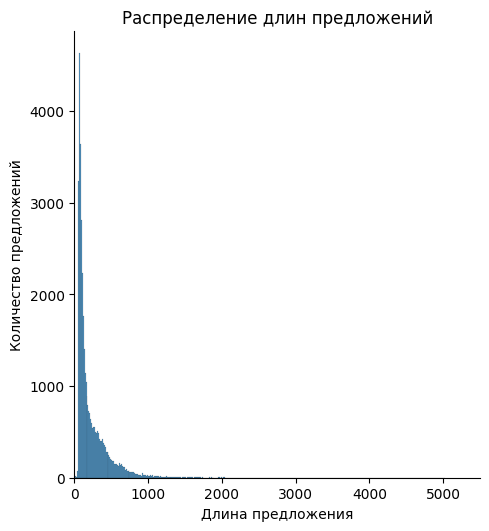

In [ ]:
lens = [len(x["text"]) for x in train_dataset]
plt.figure(figsize=(15,5))

sns.displot(lens);
plt.xlim([0, 5500])
plt.xlabel("Длина предложения")
plt.ylabel("Количество предложений")
plt.title("Распределение длин предложений")

plt.show();

Длина контекста в модели rubert-tiny составляет 2048 токенов, поэтому будет нормально ограничить длину как 512 (чтобы слишком длинные тексты не попадали) - так как мы не решаем задачу улучшения метрик и подойдет такой baseline

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 1500x500 with 0 Axes>

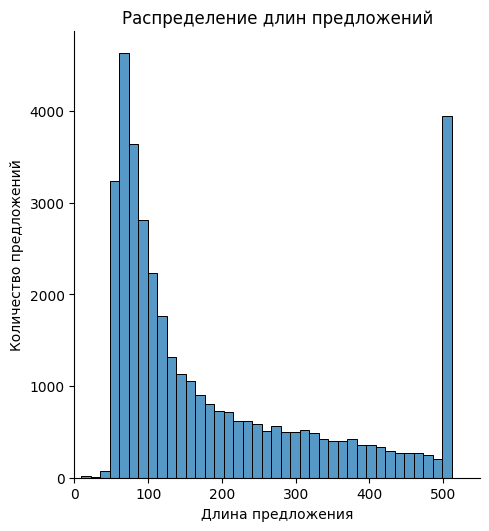

In [ ]:
lens = [len(x["text"]) for x in train_dataset]

for i, elem in enumerate(lens):
  if elem > 512:
    lens[i] = 512

plt.figure(figsize=(15,5))

sns.displot(lens);
plt.xlim([0, 550])
plt.xlabel("Длина предложения")
plt.ylabel("Количество предложений")
plt.title("Распределение длин предложений")

plt.show();

In [ ]:
max_lengths = 512

train_dataset = train_dataset.map(# применяем функцию к каждому элементу датасета
    lambda elem: tokenizer(
        elem["text"],             #  токенизируем поле text
        add_special_tokens=True,  #  автоматически добавляем CLS, SEP токены
        truncation=True,          #  обрезаем ли последовательность
        max_length=max_lengths,          #  ограничение на длину, надо выставить разумно? :)
        # padding = 'max_length', - не применяем (из условия следующей ячейки (падить будем дальше))
        return_tensors = None
    ),
    batched=True,
)

val_dataset = val_dataset.map(# применяем функцию к каждому элементу датасета
    lambda elem: tokenizer(
        elem["text"],             #  токенизируем поле text
        add_special_tokens=True,  #  автоматически добавляем CLS, SEP токены
        truncation=True,          #  обрезаем ли последовательность
        max_length=max_lengths,          #  ограничение на длину, надо выставить разумно? :)
        # padding = 'max_length', - не применяем (из условия следующей ячейки (падить будем дальше))
        return_tensors = None
    ),
    batched=True,
)

Map:   0%|          | 0/38157 [00:00<?, ? examples/s]

Map:   0%|          | 0/12719 [00:00<?, ? examples/s]

Посмотрим на элемент нашего датасета.

In [ ]:
print(train_dataset[7])

{'text': 'Начальство Грубое, Много на себя берет.... [SEP] Относится по человечески к людям. Внедрять новых людей в Директора и товароведы....', 'labels': [0, 1, 0, 0, 0, 0, 0, 0, 1], 'input_ids': [2, 1041, 12006, 1090, 1967, 283, 3098, 9422, 626, 16, 25806, 548, 4788, 22473, 751, 18, 18, 18, 18, 3, 5386, 22973, 14209, 705, 8092, 3933, 7527, 322, 27000, 18, 282, 987, 16302, 5808, 10218, 4544, 314, 284, 24730, 15896, 603, 320, 3946, 3801, 10138, 700, 18, 18, 18, 18, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


Как видим, помимо `input_ids`, которые отправятся на вход модели, у нас так же имеется `attention_mask`, а также в зависимости от модели могут быть `token_type_ids` &mdash; некоторые модели используют для задачи **NSP**.

Вообще говоря, уже на этапе токенизации мы могли бы дополнить паддингом до максимальной длины наши последовательности, это можно сделать при вызове токенизатора, используя параметр `padding`. Однако у это подхода есть недостатки, поэтому эффективнее будет выполнить паддинг в даталоадере, на этапе формирования батча, тем самым дополнив все последовательности по длине до максимальной длины в батче.

Подробнее о токенизаторах в `transformers` можно почитать по [ссылке](https://huggingface.co/docs/transformers/v4.26.1/en/main_classes/tokenizer).

Посмотрим, как расположены спец токены:

In [ ]:
tokenizer.decode(train_dataset[6]["input_ids"])

'[CLS] Компания полностью соответствующая моей специализации. Давала возможность развиваться. В то время, когда я работала [SEP] Брать сотрудников с большим опытом ( и возрастом ).... [SEP]'

Избавимся от теперь ненужного поля `text`.

In [ ]:
train_dataset = train_dataset.remove_columns("text")
val_dataset = val_dataset.remove_columns("text")

### Модель

Реализуем класс модели. В качестве классификатора будем использовать линейный слой, в который можно подать, например, эмбеддинг CLS-токена с последнего слоя, который можно получить следующим образом:



```
output = bert(input)
cls_token = output.last_hidden_state[:, 0, :]
logits = classifier(cls_token)
```



Важно не взять предобученную модель, чтобы увидеть разницу в следующем задании MLM лучше - так и сделаем:

In [ ]:
class Model(nn.Module):
    def __init__(self, model_name="cointegrated/rubert-tiny", num_labels=9):
        super().__init__()

        config = AutoConfig.from_pretrained(model_name)
        self.bert = AutoModel.from_config(config)

        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, batch):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_token = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(cls_token)
        return logits

In [ ]:
batch_size = 8
dummy_input = {
    "input_ids" : torch.randint(0, 20000, (batch_size, 256)),
    "attention_mask" : torch.randint(0, 1, (batch_size, 256))}
model = Model()

# model(dummy_input), (batch_size, 9)
assert model(dummy_input).shape == (batch_size, 9)

### Пайплайн обучения

1. Реализуем пайплайн обучения и обучим модель.
2. Cначала обучим только последний линейный слой, заморозив веса языковой модели, а затем всю модель целиком.


In [ ]:
BATCH_SIZE = 64

data_collator = DataCollatorWithPadding(tokenizer)

train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          collate_fn=data_collator)

val_loader = DataLoader(val_dataset,
                        batch_size = BATCH_SIZE,
                        shuffle=False,
                        collate_fn=data_collator)

Посмотрим на батч данных.

In [ ]:
next(iter(train_loader))

{'labels': tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 

**Обучение модели:**

In [ ]:
model = Model(model_name="cointegrated/rubert-tiny", num_labels=9)
model.to(device)

Model(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29564, 312, padding_idx=0)
      (position_embeddings): Embedding(512, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=Tr

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = BCEWithLogitsLoss()

In [ ]:
model = Model(model_name="cointegrated/rubert-tiny", num_labels=9)
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = BCEWithLogitsLoss()

NUM_EPOCH = 5
for epoch in range(NUM_EPOCH):
    model.train()
    for batch in tqdm(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        logits = model(batch)
        loss = criterion(logits, batch["labels"].float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

100%|██████████| 597/597 [02:34<00:00,  3.86it/s]


Epoch 1, Loss: 0.2046225219964981


100%|██████████| 597/597 [02:39<00:00,  3.73it/s]


Epoch 2, Loss: 0.06669429689645767


100%|██████████| 597/597 [02:40<00:00,  3.71it/s]


Epoch 3, Loss: 0.22609888017177582


100%|██████████| 597/597 [02:41<00:00,  3.69it/s]


Epoch 4, Loss: 0.04858991131186485


100%|██████████| 597/597 [02:42<00:00,  3.67it/s]

Epoch 5, Loss: 0.03412898629903793


Провалидируем модель:

In [ ]:
def validate_model(model, val_loader, device):
    model.eval()
    val_preds = []
    val_targets = []

    with torch.no_grad():
        for batch in tqdm(val_loader):
            batch = {k: v.to(device) for k, v in batch.items()}
            logits = model(batch)

            preds = torch.sigmoid(logits) > 0.5

            val_preds.extend(preds.cpu().numpy())
            val_targets.extend(batch["labels"].cpu().numpy())

    f1 = calculate_f1_score(np.array(val_preds), np.array(val_targets))
    return f1

In [ ]:
val_f1 = validate_model(model, val_loader, device)
val_f1

100%|██████████| 199/199 [00:17<00:00, 11.52it/s]


0.7837094111172263

Получился довольно хороший результат, однако так как от трешхолда может много что зависеть - подберем его с помощью gridsearch (так как только по 1 размерности):

In [ ]:
def find_optimal_threshold(model, val_loader, device):
    model.eval()
    val_preds = []
    val_targets = []

    with torch.no_grad():
        for batch in tqdm(val_loader):

            batch = {k: v.to(device) for k, v in batch.items()}
            logits = model(batch)

            preds = torch.sigmoid(logits)

            val_preds.extend(preds.cpu().numpy())
            val_targets.extend(batch["labels"].cpu().numpy())

    val_preds = np.array(val_preds)
    val_targets = np.array(val_targets)

    # Перебираем пороги и выбираем лучший
    best_threshold = 0.5
    best_f1 = 0

    for threshold in np.arange(0.1, 1.0, 0.05):
        preds = val_preds > threshold
        f1 = calculate_f1_score(val_targets, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold, best_f1

optimal_threshold, optimal_f1 = find_optimal_threshold(model, val_loader, device)
print(f"Optimal threshold: {optimal_threshold}, F1-score: {optimal_f1}")

100%|██████████| 199/199 [00:17<00:00, 11.46it/s]


Optimal threshold: 0.30000000000000004, F1-score: 0.8074927274156773


Действительно, понижение трешхолда с 0.5 до 0.3 увеличило f1-score довольно неплохо

### MLM pretraining

Попробуем улучшить качество, предварительно обучив выбранную модель на задачу **MLM** на обучающем датасете. Будет достаточно 1-2 эпох. Воспользуйтесь [примерами](https://github.com/huggingface/transformers/tree/main/examples/pytorch/language-modeling) из репозитория. Правильно организовав файл с обучающими данными, остается лишь воспользоваться готовым скриптом.

Организуем обучающие данные немного по другому:

In [ ]:
with open("/kaggle/working/mlm_data.txt", "w", encoding="utf-8") as f:
    for _, row in train_dataset.iterrows():
        text = str(row["positive"]) + " " + str(row["negative"])
        f.write(text + "\n")

Воспользуемся готовой функцией из репозитория huggingface для MLM:

In [ ]:
!git clone https://github.com/huggingface/transformers
%cd transformers
!pip install -e .

Cloning into 'transformers'...
remote: Enumerating objects: 260744, done.
remote: Counting objects: 100% (294/294), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 260744 (delta 221), reused 155 (delta 148), pack-reused 260450 (from 3)
Receiving objects: 100% (260744/260744), 270.78 MiB | 23.13 MiB/s, done.
Resolving deltas: 100% (192584/192584), done.
/kaggle/working/transformers
Obtaining file:///kaggle/working/transformers
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for transformers (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.50.0.dev0-0.editable-py3-none-any.whl size=17532 sha256=0767d9f0f1ac360a9c0669fe13953fc509cde5e2c16dbf29c68e089ffa346ba7
  Stored in directory: /tmp/pip-ephem-wheel-cache-11qieqdt/wheels/7e/b2/24/0b3be37b3b423a6f2fd25f

In [ ]:
!python examples/pytorch/language-modeling/run_mlm.py \
    --model_name_or_path cointegrated/rubert-tiny \
    --train_file /kaggle/working/mlm_data.txt \
    --output_dir /kaggle/working/mlm_checkpoint \
    --do_train \
    --num_train_epochs 2 \
    --per_device_train_batch_size 16 \
    --save_steps 500 \
    --save_total_limit 2 \
    --overwrite_output_dir \
    --line_by_line \
    --max_seq_length 512 \
    --report_to none

2025-03-07 18:32:30.735736: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-07 18:32:30.757418: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-07 18:32:30.764010: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Using custom data configuration default-78e7c0d6f6f19af1
Loading Dataset Infos from /usr/local/lib/python3.10/dist-packages/datasets/packaged_modules/text
Generating dataset text (/root/.cache/huggingface/datasets/text/default-78e7c0d6f6f19af1/0.0.0/37eaf37ac90527a7fd768c94b312ee84f8815c9b7ac00acf81c1c364e8392f99)
Checksum Computation took 0.0 min
Generating trai

Обучите модель, полученную после процедуры **MLM** претрейна.

Загрузим дообученную модель:

In [ ]:
model_path = "/kaggle/working/mlm_checkpoint"

model = AutoModel.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

Some weights of BertModel were not initialized from the model checkpoint at /kaggle/working/mlm_checkpoint and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model_path = "/kaggle/working/mlm_checkpoint"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModel.from_pretrained(model_path)

class Model(nn.Module):
    def __init__(self, model_name, num_labels=9):
        super().__init__()

        self.bert = AutoModel.from_pretrained(model_name)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, batch):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_token = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(cls_token)
        return logits

model = Model(model_name=model_path, num_labels=9)
model.to(device)

Some weights of BertModel were not initialized from the model checkpoint at /kaggle/working/mlm_checkpoint and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertModel were not initialized from the model checkpoint at /kaggle/working/mlm_checkpoint and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29564, 312, padding_idx=0)
      (position_embeddings): Embedding(512, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=Tr

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
NUM_EPOCH = 5
for epoch in range(NUM_EPOCH):
    model.train()
    for batch in tqdm(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        logits = model(batch)
        loss = criterion(logits, batch["labels"].float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

100%|██████████| 597/597 [02:44<00:00,  3.63it/s]


Epoch 1, Loss: 0.16535529494285583


100%|██████████| 597/597 [02:44<00:00,  3.63it/s]


Epoch 2, Loss: 0.11845670640468597


100%|██████████| 597/597 [02:43<00:00,  3.66it/s]


Epoch 3, Loss: 0.11320468783378601


100%|██████████| 597/597 [02:41<00:00,  3.70it/s]


Epoch 4, Loss: 0.16652706265449524


100%|██████████| 597/597 [02:40<00:00,  3.71it/s]

Epoch 5, Loss: 0.08311042189598083


In [ ]:
def validate_model(model, val_loader, device):
    model.eval()
    val_preds = []
    val_targets = []

    with torch.no_grad():
        for batch in tqdm(val_loader):
            batch = {k: v.to(device) for k, v in batch.items()}
            logits = model(batch)

            preds = torch.sigmoid(logits) > 0.5

            val_preds.extend(preds.cpu().numpy())
            val_targets.extend(batch["labels"].cpu().numpy())

    f1 = calculate_f1_score(np.array(val_preds), np.array(val_targets))
    return f1

In [ ]:
val_f1 = validate_model(model, val_loader, device)
val_f1

100%|██████████| 199/199 [00:17<00:00, 11.47it/s]


0.808441439316508

Качество по крайне мере на трешхолде 0.5 точно уже улучшилось, оно получило даже немного лучше чем при подборе оптимального трешхолда в предыдущем случае

попробуем подобрать оптимальный трешхолд для этой модели как мы делали для модели без MLM:

In [ ]:
def find_optimal_threshold(model, val_loader, device):
    model.eval()
    val_preds = []
    val_targets = []

    with torch.no_grad():
        for batch in tqdm(val_loader):

            batch = {k: v.to(device) for k, v in batch.items()}
            logits = model(batch)

            preds = torch.sigmoid(logits)

            val_preds.extend(preds.cpu().numpy())
            val_targets.extend(batch["labels"].cpu().numpy())

    val_preds = np.array(val_preds)
    val_targets = np.array(val_targets)

    # Перебираем пороги и выбираем лучший
    best_threshold = 0.5
    best_f1 = 0

    for threshold in np.arange(0.1, 1.0, 0.05):
        preds = val_preds > threshold
        f1 = calculate_f1_score(val_targets, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold, best_f1

optimal_threshold, optimal_f1 = find_optimal_threshold(model, val_loader, device)
print(f"Optimal threshold: {optimal_threshold}, F1-score: {optimal_f1}")

100%|██████████| 199/199 [00:17<00:00, 11.21it/s]


Optimal threshold: 0.30000000000000004, F1-score: 0.8281049348743351


Трешхолд получился такой же, однако качество увеличилось на 0.02 единиц f1-score

**Вывод:**
Поработали с новой библиотекой transformers и необычной задачей c несколькими таргетами

В ходе работы выбрали маленькую модель для недорогого обучения

Можно выделить несколько особенностей по итоге задания:
* Использование MLM улучшает понимание языка модели, именно поэтому любую модель перед обучением на основной задаче предобучают предсказывать замаскированные токены (MLM)
* Подбирать максимальную длину предложения следует с умом - так как если сообщение большое, то не факт что оно информативное, однако это может 'взломать' нашу модель, но конкретно тут мы не акцентируем на этом внимание
* Много полезных функций уже реализованы в transformers - нужно немного переорганизовать датасет для использования
* Следует подбирать трешхолд в такого типа задачах по валидационной выборке